<a href="https://colab.research.google.com/github/SanjaySaatyaki/pytorch_4_ml_dl/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

classificaiton is predicting where something is one thing or other.(there can be multiple things as options)

In [5]:
import torch
from sklearn.datasets import make_circles

In [6]:
#make 1000 samples
n_samples = 1000

In [7]:
X, y = make_circles(n_samples,noise=0.03,random_state=42)

In [8]:
len(X),len(y)

(1000, 1000)

In [9]:
print(X[:5]),;print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [10]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

In [11]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


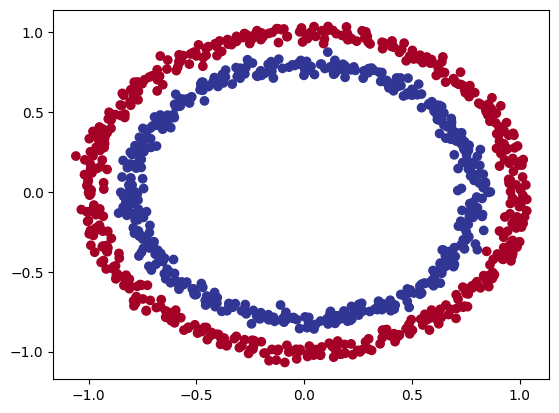

In [12]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [13]:
X.shape, y.shape

((1000, 2), (1000,))

In [14]:
X_sample = X[0]
y_sample = y[0]
print(f"{X_sample}:{y_sample}")

[0.75424625 0.23148074]:1


In [15]:
### Turn data in tensors and create train and test splits
import torch
torch.__version__

'2.6.0+cu124'

In [16]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [17]:
X.dtype

torch.float32

In [18]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building a model

Lets build a model to classify our blue and red dots

To do so, we want to,
1. Setup device agonistic code so our code will run on a accelerator
2.Construct a model
3.Define a loss function and optimizer
4. Creating a training and test loop

In [20]:
import torch
from torch import nn

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
device

'cpu'

In [23]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

- Subclasses `nn.module` (almost all models in Pytorch subclass `nn.module`
- Create 2 `nn.linear()`
- Define `forward()` method that outlines the forward pass

In [24]:
class circle_model_v1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = circle_model_v1().to(device)

In [25]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.2500,  0.0444],
         [-0.6806, -0.5433],
         [ 0.5079,  0.1407],
         [ 0.4711,  0.1528],
         [ 0.3790, -0.6045]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2479, -0.5575, -0.0496, -0.4582,  0.3633], requires_grad=True),
 Parameter containing:
 tensor([[-0.0598,  0.4418,  0.0151, -0.3527,  0.1955]], requires_grad=True),
 Parameter containing:
 tensor([0.1593], requires_grad=True)]

In [26]:
model_0

circle_model_v1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

In [28]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
with torch.inference_mode():
  un_trained_preds = model_0(X_test)

In [30]:
len(un_trained_preds), un_trained_preds.shape

(200, torch.Size([200, 1]))

- Regression: MSE or MAE
- Classification: cross entropy or categorical cross entropy

In [31]:
#Setup Loss function
# loss_fn = nn.BCE_Loss() requires to have gone through the sigmoid activation function prior to input to BCE Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [32]:
#Calculate accuracy:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

Model outputs are going to be raw **logits**
We can convert these **logists** into prediction probabilities by passing them to some kind of activation function(Sigmoid for binary, Softmax for multiclass)

Convert models's prediction probabilites to **prediction labels** by either round them -Binary or taking argmax()- Multiclass

In [33]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)[:5]
y_logits

tensor([[0.3362],
        [0.2508],
        [0.5120],
        [0.2866],
        [0.4356]])

In [34]:
# Using sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5833],
        [0.5624],
        [0.6253],
        [0.5712],
        [0.6072]])

In [35]:
y_pred = torch.round(y_pred_probs)

In [36]:
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device)[:5])))

In [37]:
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [38]:
torch.manual_seed(42)
epochs = 300

X_train, y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):

  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # loss = loss_fn(torch.signmoid(y_logits),y_train) incase of nn.BCELoss expects predictions probabilites as input
  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true =y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}| Train Loss:{loss} | Train acc:{acc:.2f}% | Test loss:{loss} | Test acc:{test_acc:.2f}%")


Epoch 0| Train Loss:0.714280903339386 | Train acc:50.00% | Test loss:0.714280903339386 | Test acc:50.00%
Epoch 10| Train Loss:0.712401270866394 | Train acc:50.00% | Test loss:0.712401270866394 | Test acc:50.00%
Epoch 20| Train Loss:0.7106949090957642 | Train acc:50.00% | Test loss:0.7106949090957642 | Test acc:50.00%
Epoch 30| Train Loss:0.7091456651687622 | Train acc:50.00% | Test loss:0.7091456651687622 | Test acc:50.00%
Epoch 40| Train Loss:0.7077386975288391 | Train acc:50.00% | Test loss:0.7077386975288391 | Test acc:50.00%
Epoch 50| Train Loss:0.7064609527587891 | Train acc:50.00% | Test loss:0.7064609527587891 | Test acc:50.00%
Epoch 60| Train Loss:0.7053000926971436 | Train acc:50.00% | Test loss:0.7053000926971436 | Test acc:50.00%
Epoch 70| Train Loss:0.7042454481124878 | Train acc:50.00% | Test loss:0.7042454481124878 | Test acc:50.00%
Epoch 80| Train Loss:0.7032869458198547 | Train acc:50.00% | Test loss:0.7032869458198547 | Test acc:50.00%
Epoch 90| Train Loss:0.7024159431

# Make prediction and evaluvate the model
To inspect lets make visual predictions

In [39]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping downloading")
else:
  print("Download Helper function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

Download Helper function


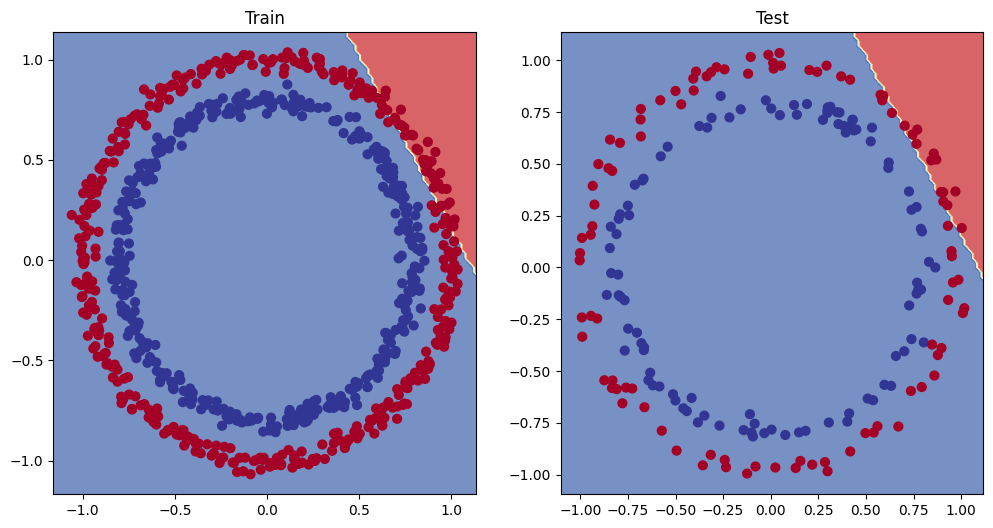

In [40]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

# Improving a model
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

parameters - model updates id
hyperparameter - paramter that user can change

In [41]:
class circle_model_v2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) #Leveraging speeding

In [42]:
model_v2 = circle_model_v2().to(device)
model_v2

circle_model_v2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
#Create loss function
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),lr=0.01)

In [44]:
epochs =1000

for epoch in range(epochs):
  model_v2.train()

  y_logits = model_v2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v2.eval()
  with torch.inference_mode():
    test_logits = model_v2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}| Loss: {loss:5f}, Acc:{acc:.2f}%, Test Loss: {test_loss:5f}, Test acc: {test_acc:2f}%")

Epoch: 0| Loss: 0.693955, Acc:50.88%, Test Loss: 0.692611, Test acc: 51.000000%
Epoch: 100| Loss: 0.693690, Acc:50.25%, Test Loss: 0.692693, Test acc: 50.000000%
Epoch: 200| Loss: 0.693515, Acc:50.12%, Test Loss: 0.692817, Test acc: 49.500000%
Epoch: 300| Loss: 0.693388, Acc:50.50%, Test Loss: 0.692952, Test acc: 49.000000%
Epoch: 400| Loss: 0.693294, Acc:50.38%, Test Loss: 0.693088, Test acc: 48.500000%
Epoch: 500| Loss: 0.693222, Acc:49.88%, Test Loss: 0.693221, Test acc: 49.500000%
Epoch: 600| Loss: 0.693168, Acc:49.50%, Test Loss: 0.693347, Test acc: 53.000000%
Epoch: 700| Loss: 0.693126, Acc:49.38%, Test Loss: 0.693467, Test acc: 50.500000%
Epoch: 800| Loss: 0.693093, Acc:50.00%, Test Loss: 0.693579, Test acc: 51.000000%
Epoch: 900| Loss: 0.693068, Acc:50.62%, Test Loss: 0.693682, Test acc: 47.500000%


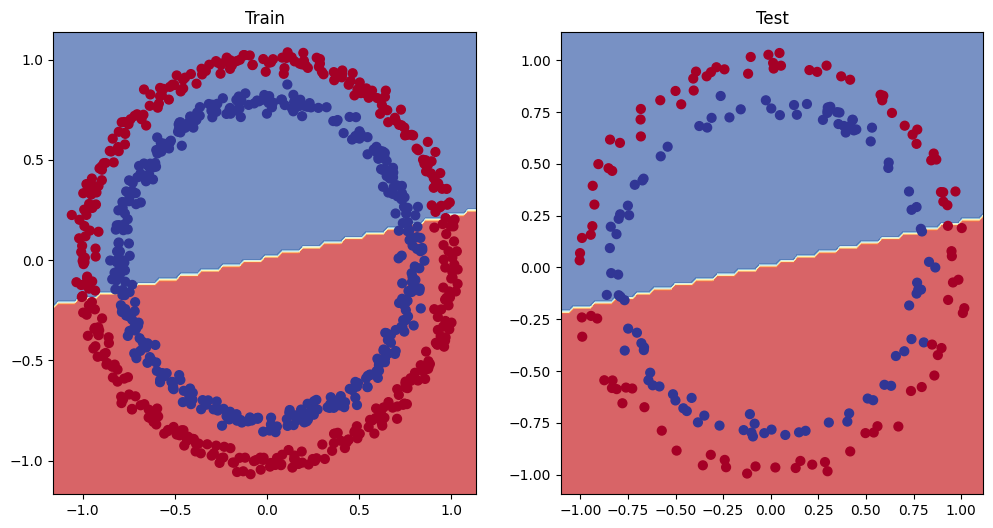

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v2,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v2,X_test,y_test)

## Preparding data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [46]:
weight = 0.7
bias =0.3
start = 0
end =1
step =0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [47]:
train_split = int(0.8 * len(X_regression))

X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]

In [48]:
from helper_functions import plot_predictions

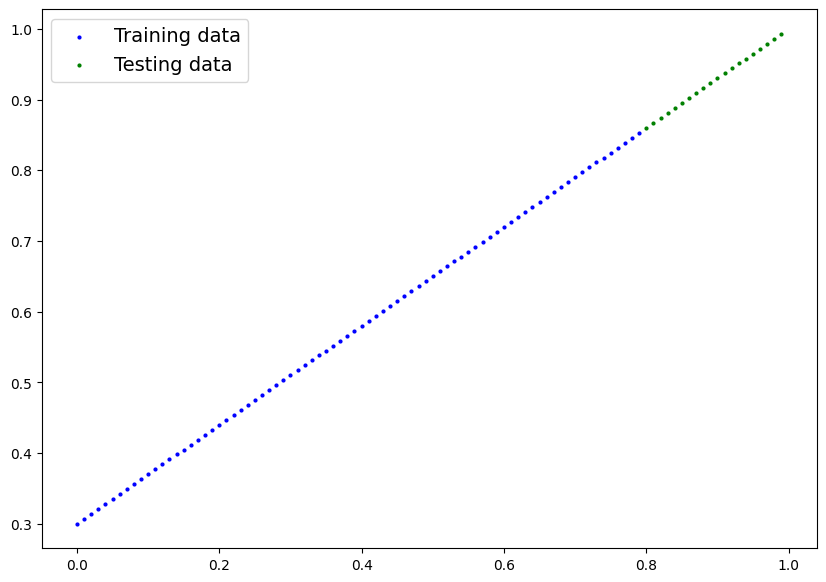

In [49]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)


In [50]:
model_v3 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
)

In [51]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_v3.parameters(),lr=0.1)

In [52]:
epochs = 2000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)

In [53]:
for epoch in range(epochs):
  model_v3.train()
  y_pred = model_v3(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_v3.eval()
  with torch.inference_mode():
    test_pred = model_v3(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch %100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.57896 | Test Loss: 0.47265
Epoch: 100 | Loss: 0.05652 | Test Loss: 0.17491
Epoch: 200 | Loss: 0.05272 | Test Loss: 0.15038
Epoch: 300 | Loss: 0.05733 | Test Loss: 0.14733
Epoch: 400 | Loss: 0.05780 | Test Loss: 0.14758
Epoch: 500 | Loss: 0.04943 | Test Loss: 0.12419
Epoch: 600 | Loss: 0.05283 | Test Loss: 0.14350
Epoch: 700 | Loss: 0.07244 | Test Loss: 0.12574
Epoch: 800 | Loss: 0.04493 | Test Loss: 0.11135
Epoch: 900 | Loss: 0.05377 | Test Loss: 0.13252
Epoch: 1000 | Loss: 0.05325 | Test Loss: 0.14367
Epoch: 1100 | Loss: 0.04654 | Test Loss: 0.10178
Epoch: 1200 | Loss: 0.05776 | Test Loss: 0.13082
Epoch: 1300 | Loss: 0.06252 | Test Loss: 0.12469
Epoch: 1400 | Loss: 0.04877 | Test Loss: 0.11476
Epoch: 1500 | Loss: 0.05837 | Test Loss: 0.13782
Epoch: 1600 | Loss: 0.04967 | Test Loss: 0.13376
Epoch: 1700 | Loss: 0.04334 | Test Loss: 0.13069
Epoch: 1800 | Loss: 0.03799 | Test Loss: 0.13244
Epoch: 1900 | Loss: 0.05011 | Test Loss: 0.11154


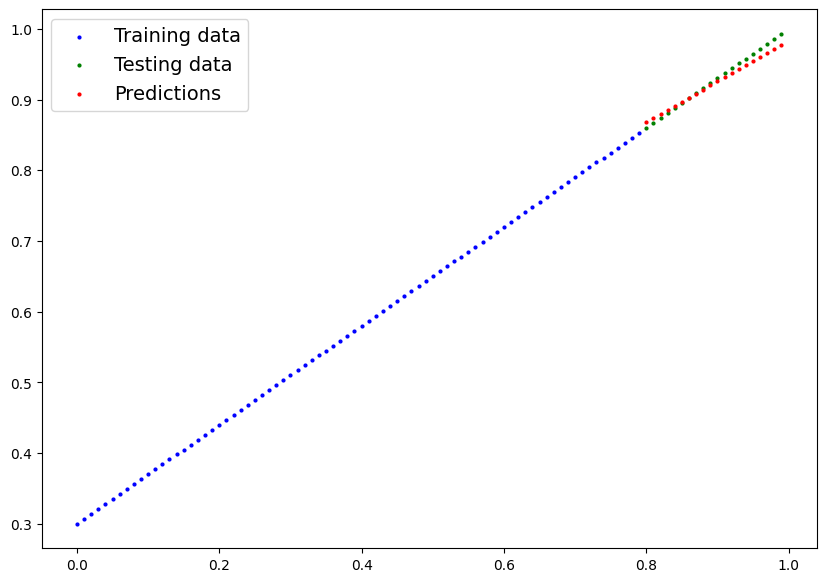

In [54]:
model_v3.eval()
with torch.inference_mode():
  preds = model_v3(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=preds)


Non Linearity



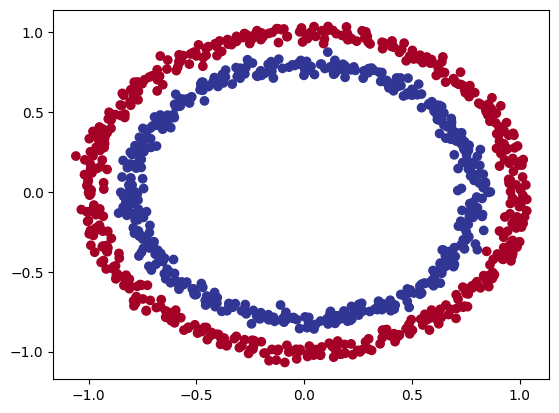

In [55]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [56]:
#Convert data to tensors and then train and test splits

import torch
from sklearn.model_selection import train_test_split

X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [57]:
# Build a model with non linear activation functions
from torch import nn

class circle_model_v3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() #non linear activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [58]:
model_v4 = circle_model_v3().to(device)
model_v4

circle_model_v3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [59]:
#Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v4.parameters(),lr=0.1)

In [60]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

In [61]:
epoch =1000

for epoch in range(epochs):
  model_v4.train()

  y_logits = model_v4(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true=y_train,y_pred= y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v4.eval()

  with torch.inference_mode():
    test_logits = model_v4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,test_pred)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 ==0:
    print(f"Epoch : {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test acc:{test_acc:.2f}")


Epoch : 0 | Loss: 0.6928 | Acc: 52.62 | Test Loss: 0.6702 | Test acc:52.00
Epoch : 100 | Loss: 0.6897 | Acc: 52.38 | Test Loss: 0.6744 | Test acc:52.00
Epoch : 200 | Loss: 0.6873 | Acc: 56.38 | Test Loss: 0.6747 | Test acc:55.50
Epoch : 300 | Loss: 0.6839 | Acc: 56.75 | Test Loss: 0.6714 | Test acc:54.50
Epoch : 400 | Loss: 0.6782 | Acc: 61.62 | Test Loss: 0.6666 | Test acc:62.00
Epoch : 500 | Loss: 0.6681 | Acc: 78.50 | Test Loss: 0.6579 | Test acc:78.00
Epoch : 600 | Loss: 0.6489 | Acc: 85.88 | Test Loss: 0.6412 | Test acc:87.00
Epoch : 700 | Loss: 0.6110 | Acc: 91.25 | Test Loss: 0.6083 | Test acc:90.00
Epoch : 800 | Loss: 0.5366 | Acc: 94.12 | Test Loss: 0.5451 | Test acc:94.00
Epoch : 900 | Loss: 0.4122 | Acc: 96.88 | Test Loss: 0.4344 | Test acc:93.50
Epoch : 1000 | Loss: 0.2657 | Acc: 99.50 | Test Loss: 0.2988 | Test acc:97.00
Epoch : 1100 | Loss: 0.2019 | Acc: 97.38 | Test Loss: 0.2197 | Test acc:97.00
Epoch : 1200 | Loss: 0.1089 | Acc: 100.00 | Test Loss: 0.1392 | Test acc:100

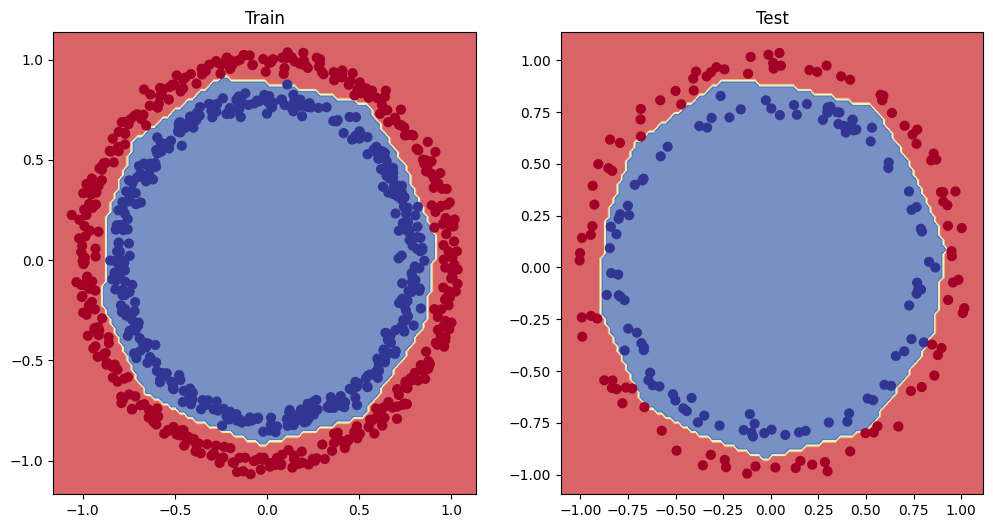

In [62]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v4,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v4,X_test,y_test)

Replication non linear activation functions

In [63]:
A = torch.arange(-10,10,1.0)

In [64]:
A.dtype

torch.float32

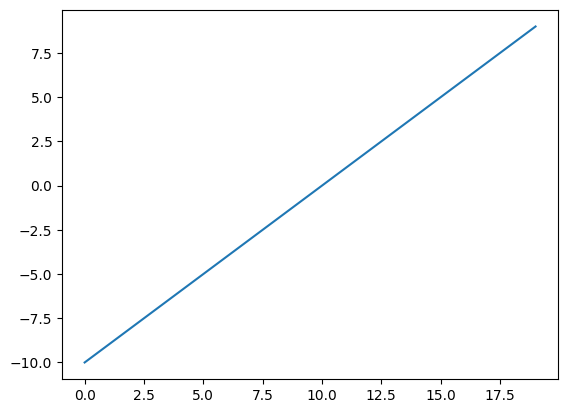

In [65]:
plt.plot(A)

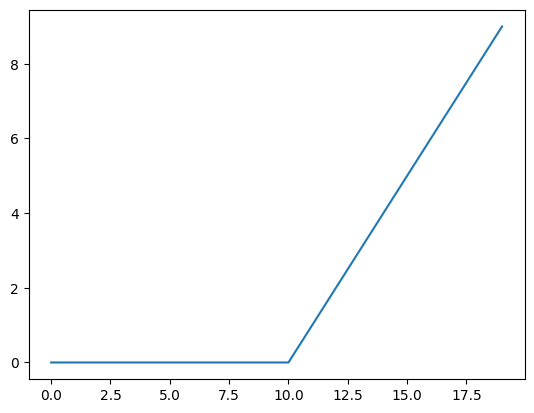

In [66]:
plt.plot(torch.relu(A))

In [67]:
def relu(x: torch.Tensor):
  return torch.maximum(torch.tensor(0),x)

## Putting it all together with multi class classification

- Binary Classification : One thing or another
- Mutli Class Classfication :more than one thing or another (cat vs dog vs chicken)

In [68]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [69]:
NUM_CLASSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features= NUM_FEATURES, centers = NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

In [70]:
#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test,y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2, random_state=RANDOM_SEED)

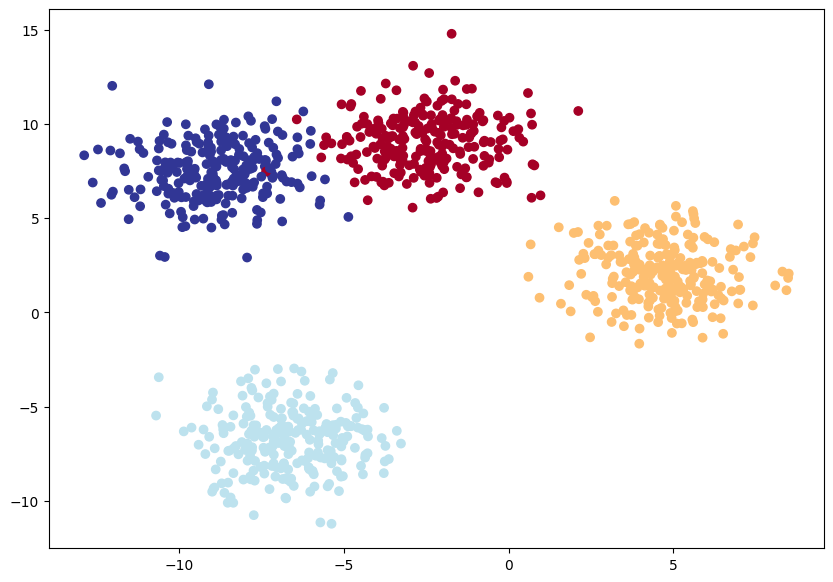

In [71]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

# Hypermeters
- Input layer shape
- Hidden layers
- Neurons per hidden layers
- Output layer shape
- Hidden layer activation
- Output activation
- Loss function
- Optimizer

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [73]:
class blob_model(nn.Module):
  def __init__(self, input_features,output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_v5 = blob_model(input_features=2, output_features=4,hidden_units=8).to(device)


In [74]:
list(model_v5.parameters())

[Parameter containing:
 tensor([[ 0.5520,  0.6799],
         [-0.3445, -0.5158],
         [ 0.5673,  0.5541],
         [-0.5399, -0.0547],
         [-0.6973, -0.5788],
         [ 0.1366,  0.1881],
         [ 0.1499, -0.1924],
         [ 0.6524,  0.1011]], requires_grad=True),
 Parameter containing:
 tensor([-0.4173, -0.0400,  0.1698,  0.2476, -0.5000,  0.2650, -0.3612, -0.5876],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1931,  0.3410,  0.3022,  0.3166,  0.2075,  0.2671, -0.0473, -0.1945],
         [ 0.1767, -0.1832, -0.2386, -0.1129,  0.0742,  0.1820, -0.1373, -0.2081],
         [ 0.0477, -0.2084, -0.2302,  0.1843, -0.0594,  0.3231,  0.3439,  0.1057],
         [ 0.1217,  0.0814,  0.0055, -0.0257,  0.0049,  0.1320,  0.3287, -0.0916],
         [-0.1495, -0.0856, -0.1708,  0.0601,  0.2639,  0.2765,  0.1623, -0.2602],
         [-0.1898, -0.0777, -0.0652,  0.0291, -0.3246,  0.1100, -0.2697, -0.2237],
         [-0.2939,  0.3081, -0.3348,  0.2667, -0.0119, -0.0411,  0.2

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_v5.parameters(),lr =0.1)

In [76]:
model_v5.eval()
with torch.inference_mode():
  y_logits = model_v5(X_blob_train.to(device))

y_logits[:10]

tensor([[-1.9485, -2.4747, -1.8822,  3.5112],
        [-0.9723, -1.1912, -1.1451,  1.7780],
        [ 2.7634,  4.3695,  4.5387, -6.5408],
        [ 1.5980,  2.6531,  2.8460, -3.9931],
        [-0.5121, -0.5059, -0.4435,  0.7524],
        [-1.5375, -1.9631, -1.6987,  2.8563],
        [-0.6466, -0.7385, -0.7910,  1.1361],
        [-1.5731, -1.9332, -1.3874,  2.7202],
        [ 0.7099,  1.2473,  1.1253, -1.7977],
        [-0.5859, -0.6303, -0.6199,  0.9545]])

In [77]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.9485, -2.4747, -1.8822,  3.5112],
        [-0.9723, -1.1912, -1.1451,  1.7780],
        [ 2.7634,  4.3695,  4.5387, -6.5408],
        [ 1.5980,  2.6531,  2.8460, -3.9931],
        [-0.5121, -0.5059, -0.4435,  0.7524]])
tensor([[4.2071e-03, 2.4857e-03, 4.4956e-03, 9.8881e-01],
        [5.4667e-02, 4.3920e-02, 4.5991e-02, 8.5542e-01],
        [8.4134e-02, 4.1929e-01, 4.9657e-01, 7.6601e-06],
        [1.3589e-01, 3.9028e-01, 4.7333e-01, 5.0695e-04],
        [1.5109e-01, 1.5203e-01, 1.6182e-01, 5.3506e-01]])


In [78]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [79]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [80]:
y_preds = torch.argmax(y_pred_probs,dim=1)

In [81]:
y_preds

tensor([3, 3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2, 1, 3,
        1, 2, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 3, 3, 1, 3, 3, 2, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 2, 2, 1, 3, 3, 2, 3, 1, 2, 2, 2, 3, 3, 2,
        1, 3, 3, 3, 2, 3, 3, 3, 2, 1, 3, 1, 1, 2, 1, 1, 2, 2, 3, 3, 3, 3, 2, 3,
        1, 3, 2, 3, 1, 1, 1, 3, 2, 3, 2, 1, 3, 3, 2, 3, 1, 1, 2, 2, 2, 3, 1, 2,
        3, 3, 2, 2, 3, 3, 2, 3, 1, 1, 2, 1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 3, 1, 3, 1, 3, 1, 3, 2, 3, 3,
        2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 3, 1, 2, 3, 1, 2, 1, 3, 1, 3, 3, 2, 2, 2,
        2, 2, 2, 3, 1, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1,
        3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 1, 1, 2,
        3, 2, 3, 1, 3, 1, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2,
        2, 1, 3, 3, 3, 2, 1, 3, 2, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 3,
        2, 2, 2, 2, 1, 3, 1, 2, 3, 2, 1,

Logits -> Prediction Probabilites (torch.softmax) -> Prediction labels(torch.argmax)

In [82]:
epochs = 100

for epoch in range(epochs):
  model_v5.train()

  y_logits = model_v5(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,y_pred=y_pred)
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v5.eval()
  with torch.inference_mode():
    test_logits = model_v5(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,y_pred = test_preds)

  if epoch % 10 ==0:
    print(f"Epoch {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f}% |Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch 0 | Train Loss: 3.20801 | Acc: 24.75% |Test Loss: 0.84643 | Test Acc: 68.00%
Epoch 10 | Train Loss: 0.19737 | Acc: 98.88% |Test Loss: 0.17333 | Test Acc: 99.50%
Epoch 20 | Train Loss: 0.09609 | Acc: 98.88% |Test Loss: 0.08598 | Test Acc: 99.50%
Epoch 30 | Train Loss: 0.06712 | Acc: 99.00% |Test Loss: 0.05857 | Test Acc: 99.50%
Epoch 40 | Train Loss: 0.05419 | Acc: 99.00% |Test Loss: 0.04582 | Test Acc: 99.50%
Epoch 50 | Train Loss: 0.04703 | Acc: 99.00% |Test Loss: 0.03859 | Test Acc: 99.50%
Epoch 60 | Train Loss: 0.04254 | Acc: 99.00% |Test Loss: 0.03397 | Test Acc: 99.50%
Epoch 70 | Train Loss: 0.03949 | Acc: 99.00% |Test Loss: 0.03078 | Test Acc: 99.50%
Epoch 80 | Train Loss: 0.03730 | Acc: 99.00% |Test Loss: 0.02845 | Test Acc: 99.50%
Epoch 90 | Train Loss: 0.03566 | Acc: 99.00% |Test Loss: 0.02667 | Test Acc: 99.50%


In [83]:
model_v5.eval()
with torch.inference_mode():
  y_logits = model_v5(X_blob_test)
y_logits[:10]

tensor([[  5.0600,  10.2465, -13.3990,  -8.2552],
        [  4.0888, -10.3527,   1.1524,  10.0156],
        [ -9.3820, -14.7292,  21.1134,  11.8278],
        [  1.6841,   6.9062,  -6.9463,  -5.7946],
        [  9.1924,   4.7986, -15.1327,  -2.7382],
        [  4.5701, -12.8907,   2.1810,  12.3604],
        [ -9.6109, -11.9145,  19.5849,   9.2749],
        [  7.6056,   0.7381, -10.4897,   0.6455],
        [ -9.8142, -19.6113,  24.8190,  16.1265],
        [  8.0271,   2.1841, -11.9605,  -0.5819]])

In [84]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[5.5603e-03, 9.9444e-01, 5.3513e-11, 9.1702e-09],
        [2.6597e-03, 1.4222e-09, 1.4111e-04, 9.9720e-01],
        [5.7011e-14, 2.7146e-16, 9.9991e-01, 9.2741e-05],
        [5.3672e-03, 9.9463e-01, 9.5852e-07, 3.0324e-06],
        [9.8779e-01, 1.2202e-02, 2.6940e-11, 6.5049e-06],
        [4.1355e-04, 1.0799e-11, 3.7925e-05, 9.9955e-01],
        [2.0912e-13, 2.0890e-14, 9.9997e-01, 3.3295e-05],
        [9.9801e-01, 1.0391e-03, 1.3818e-08, 9.4713e-04],
        [9.0971e-16, 5.0591e-20, 9.9983e-01, 1.6781e-04],
        [9.9693e-01, 2.8913e-03, 2.0806e-09, 1.8190e-04]])

In [85]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

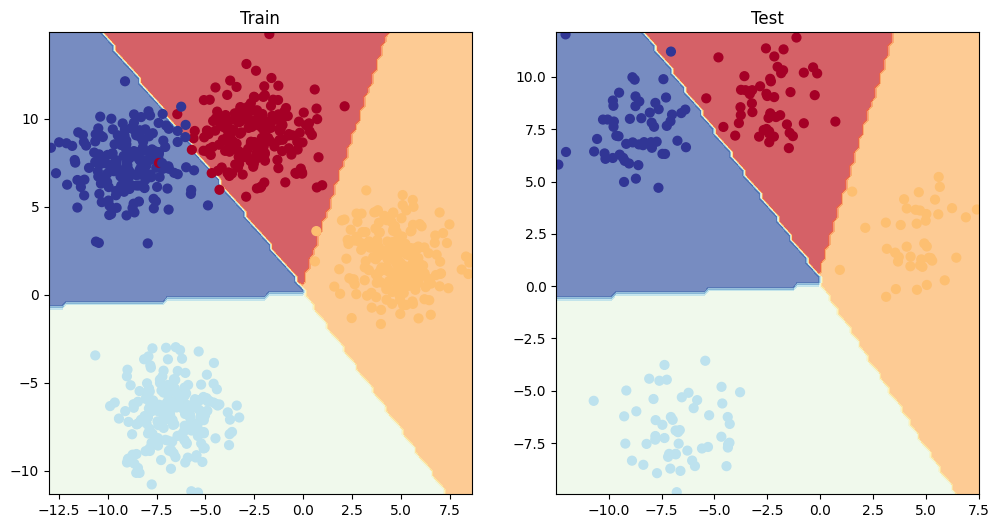

In [86]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v5,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v5,X_blob_test,y_blob_test)

- Accuracry : Out of 100 samples how many does our model get right?
- Precision
- Recall
- f1 score
- confusion matrix
- classification report

Accuracy: Not good for imbalanced dataset

Precision and Recall - https://medium.com/data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

- Higher Precision leads to less false positive
- Higher recall leads to less false negative
- F1 score - combination of Precision and recall

In [87]:
!pip install torchmetrics

In [88]:
y_blob_test.dtype

torch.int64

In [90]:
from torchmetrics import Accuracy

torch_metric_accurarcy = Accuracy(task="multiclass", num_classes=4).to(device)
torch_metric_accurarcy(y_preds,y_blob_test)

tensor(0.9950)